# Update on 14th Oct
* added reference solution for the homework
  * data augmentation
  * training more epochs
  * 0.869 acc on the test split

# Object Classification on CIFAR-10 using Keras

The CIFAR-10 [(reference)](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists on 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

![](../assets/cifar-10.png)

Source: https://www.cs.toronto.edu/~kriz/cifar.html

### system configuration
Do this when you are in a multi-user GPU station

In [1]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # how much memory to occupy
config.gpu_options.visible_device_list = "3,5"
set_session(tf.Session(config=config)) # we will create our session with the gpu id specified

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset
Keras provides convenient API to download the CIFAR-10 dataset

In [3]:
from keras.datasets import cifar10
(image_train, label_train), (image_test, label_test) = cifar10.load_data()

In [4]:
print("Train samples:", image_train.shape, label_train.shape)
print("Test samples:", image_test.shape, label_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
# https://www.cs.toronto.edu/~kriz/cifar.html
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

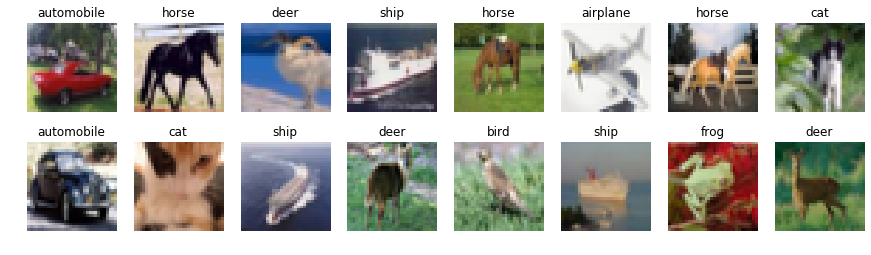

In [6]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(label_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(image_train[random_index, :])
        ax.set_title(cifar10_classes[label_train[random_index, 0]])
plt.show()

# Data Augmentation

In [7]:
image_train_flip = np.zeros((len(image_train), 32, 32, 3), dtype=np.int32)
label_train_flip = np.zeros((len(image_train), 1), dtype=np.int32)

for i in range(len(image_train)):
    image_train_flip[i] = np.fliplr(image_train[i])
    label_train_flip[i] = label_train[i]

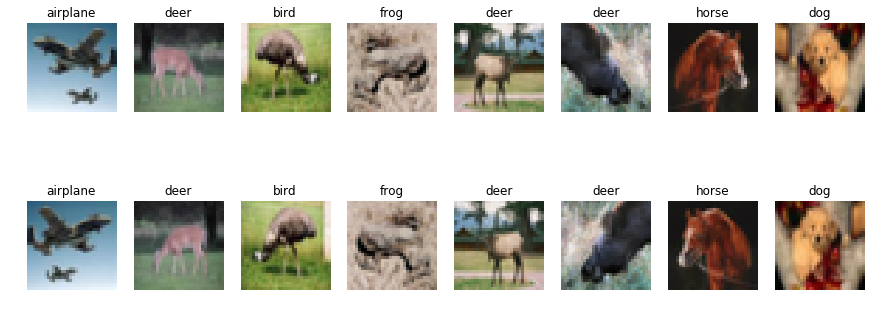

In [8]:
_, axes = plt.subplots(2, 8, figsize=(15, 6))
for i in range(8):
    idx = np.random.randint(0, len(image_train))
    axes[0][i].imshow(image_train[idx])
    axes[0][i].set_title(cifar10_classes[label_train[idx][0]])
    axes[0][i].axis('off')
    axes[1][i].imshow(image_train_flip[idx])
    axes[1][i].axis('off')
    axes[1][i].set_title(cifar10_classes[label_train_flip[idx][0]])




In [9]:
images_train = np.concatenate((image_train, image_train_flip), axis=0)
labels_train = np.concatenate((label_train, label_train_flip), axis=0)

print('new train images shape:', images_train.shape)
print('new train labels shape:', labels_train.shape)

new train images shape: (100000, 32, 32, 3)
new train labels shape: (100000, 1)


# Prepare Data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

In [10]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# normalize inputs
x_train = images_train / 255 - 0.5
x_test = image_test / 255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = to_categorical(labels_train)
y_test = to_categorical(label_test)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [12]:
print("Train samples:", x_train.shape, y_train.shape)
print("Valid samples:", x_val.shape, y_val.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (80000, 32, 32, 3) (80000, 10)
Valid samples: (20000, 32, 32, 3) (20000, 10)
Test samples: (10000, 32, 32, 3) (10000, 10)


# Build model

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
import keras
from keras import regularizers

In [34]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    # one way of defining the model
    model = Sequential()

    model.add(Conv2D(16, 3, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, 3, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, 3, padding='same',kernel_regularizer=regularizers.l2(0.01)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))

    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))
        
    return model

In [35]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
__________

# Training

In [36]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 128
EPOCHS = 50

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.95 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", keras.backend.get_value(model.optimizer.lr))

In [37]:
model_filename = 'cifar-10-solution.h5'
# fit model
training = model.fit(
            x_train, y_train,  # prepared data
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                       LrHistory(), 
                       keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True)],
            validation_data=(x_val, y_val),
            shuffle=True,
            verbose=1
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
Learning rate: 0.005
80000/80000 [==============================] - 14s 177us/step - loss: 1.4831 - acc: 0.4683 - val_loss: 1.0526 - val_acc: 0.6434
Epoch 2/50
Learning rate: 0.00475
80000/80000 [==============================] - 13s 159us/step - loss: 1.0195 - acc: 0.6579 - val_loss: 0.8476 - val_acc: 0.7202
Epoch 3/50
Learning rate: 0.0045125
80000/80000 [==============================] - 12s 152us/step - loss: 0.8753 - acc: 0.7131 - val_loss: 0.7614 - val_acc: 0.7526
Epoch 4/50
Learning rate: 0.004286875
80000/80000 [==============================] - 13s 157us/step - loss: 0.7926 - acc: 0.7428 - val_loss: 0.7239 - val_acc: 0.7665
Epoch 5/50
Learning rate: 0.004072531
80000/80000 [==============================] - 12s 155us/step - loss: 0.7327 - acc: 0.7636 - val_loss: 0.6851 - val_acc: 0.7778
Epoch 6/50
Learning rate: 0.0038689047
80000/80000 [==============================] - 12s 154us/step - loss: 0.6954 - acc: 0.7773 - 

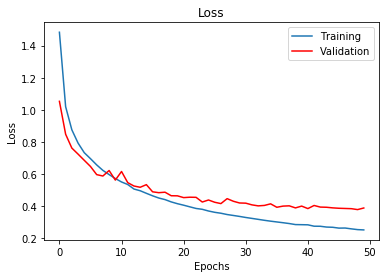

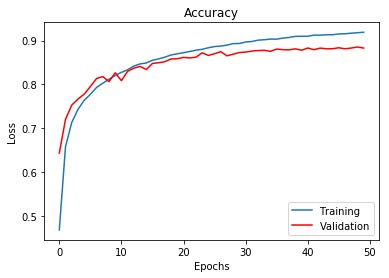

In [38]:
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

In [39]:
# load the best checkpoint
from keras.models import load_model
model = load_model(model_filename)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


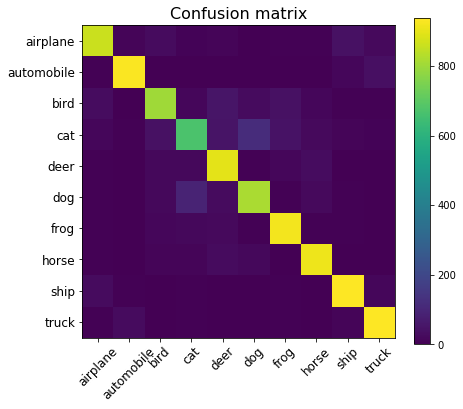

Test accuracy: 0.8692


In [40]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(label_test, y_pred_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(label_test, y_pred_classes))

# Checkpoint

In [1]:
from keras.models import load_model
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # how much memory to occupy
config.gpu_options.visible_device_list = "4"
set_session(tf.Session(config=config)) # we will create our session with the gpu id specified

Using TensorFlow backend.


In [2]:
_, (img_test, label_test) = cifar10.load_data()

In [3]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [4]:
# normalize test images as what we did for training
x_test = img_test / 255 - 0.5

In [5]:
# load model
model = load_model('./cifar-10.h5')

In [6]:
preds = model.predict(x_test)

In [7]:
preds_classes = np.argmax(preds, axis=-1)

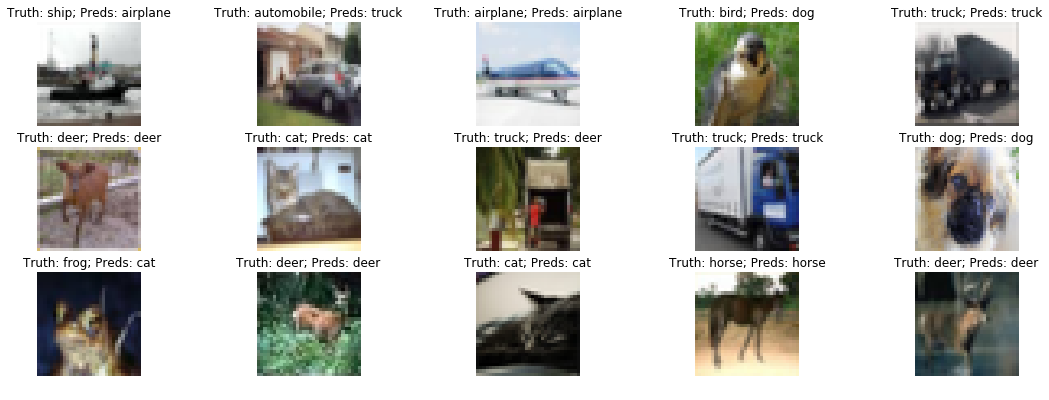

In [21]:
# show random images from train
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(x_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(img_test[random_index])
        ax.set_title('Truth: {}; Preds: {}'.format(cifar10_classes[label_test[random_index, 0]],
                                                   cifar10_classes[preds_classes[random_index]]))
plt.show()

# Benchmark on cifar-10
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

# Your homework
Submit a model which achieves at least 85% accuracy on cifar-10 test data
* You may use any model architecture.
* Try data augmentation, regularizations.
* Post your notebook and model.h5 file on github and send me the link by Sunday, 7th Oct.